# Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import choices
from string import ascii_lowercase
from scripts.visualization import plot_training_log
from scripts.utils import read_data, create_dir, read_json, save_dict_as_json
from scripts.dataloader import get_text_encoder_decoder, customize_dataloader_func
from scripts.pytorch_utils import get_model, train_and_evaluate, evaluate

# For reproducibility

This function will be called for before every model is trained.

In [2]:
import random 
import numpy as np


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# Get data

In [3]:
train = read_data("data/train.txt")
dev = read_data("data/dev.txt")
test = read_data("data/test.txt") + read_data("data/gen.txt")

test2 consists of 10,000 strings of length 10,000. It is not saved because it is a bit too large (200MB) to be saved in GitHub (for me personally).

In [4]:
test2 = set()

while len(test2) < 10000:
    w = "".join(choices(ascii_lowercase, k=10000))
    test2.add(w)

test2 = [[w, w] for w in test2]

In [5]:
len(train), len(dev), len(test), len(test2)

(10000, 10000, 150000, 10000)

## Dataloader function

In [6]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase

# in_seq_decoder will not be used anyway
in_seq_encoder, _ = get_text_encoder_decoder(in_vocab)
out_seq_encoder, out_seq_decoder = get_text_encoder_decoder(out_vocab)

In [7]:
padding_idx = 27 # does not matter here!
batch_size = 1000

dataloader_func = customize_dataloader_func(in_seq_encoder, 
                                            out_seq_encoder, 
                                            padding_idx=padding_idx, 
                                            batch_size=batch_size)

train_dl = dataloader_func(train)
dev_dl = dataloader_func(dev)
test_dl = dataloader_func(test, batch_size=5000)
test_dl2 = dataloader_func(test2)

# SRNN

## Training 

In [8]:
set_seed(3422)

In [9]:
ModelConfig = {"bias": True, 
               "rnn_type": "SRNN",
               "embd_dim": 3, 
               "num_layers": 1,
               "hidden_size": 4, 
               "dropout_rate": 0.0,
               "device": "cpu", 
               "bidirectional": False,
               "in_vocab_size": len(in_vocab),
               "out_vocab_size": len(out_vocab),
               "reduction_method": "mean"}

rnn_type = ModelConfig["rnn_type"]
create_dir(f"models/{rnn_type}")
model = get_model(ModelConfig)

./models created!
./models/SRNN created!
The model has 244 trainable parameters


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

rnn_type = ModelConfig["rnn_type"]
log = train_and_evaluate(model, train_dl, dev_dl, 
                         criterion, optimizer, 
                         acc_threshold=0.0, 
                         print_eval_freq=10, 
                         max_epoch_num=500, 
                         train_exit_acc=1.0, 
                         eval_exit_acc=1.0, 
                         saved_model_fp=f"models/{rnn_type}/model.pt", )

Current epoch: 10, 
training performance: {'loss': 1.390787160396576, 'full sequence accuracy': 0.0368, 'first n-symbol accuracy': 0.22755615662115664, 'overlap rate': 0.6985407178932178}
evaluation performance: {'loss': 1.3897033333778381, 'full sequence accuracy': 0.03780000000000001, 'first n-symbol accuracy': 0.22867960400710402, 'overlap rate': 0.699511138028638}

Current epoch: 20, 
training performance: {'loss': 0.8872578024864197, 'full sequence accuracy': 0.4351999999999999, 'first n-symbol accuracy': 0.647976674159174, 'overlap rate': 0.9220863714063714}
evaluation performance: {'loss': 0.8874038398265839, 'full sequence accuracy': 0.4439000000000001, 'first n-symbol accuracy': 0.6556754767454767, 'overlap rate': 0.9234211019536019}

Current epoch: 30, 
training performance: {'loss': 0.6562195420265198, 'full sequence accuracy': 0.4351999999999999, 'first n-symbol accuracy': 0.647976674159174, 'overlap rate': 0.9220863714063714}
evaluation performance: {'loss': 0.655946111679

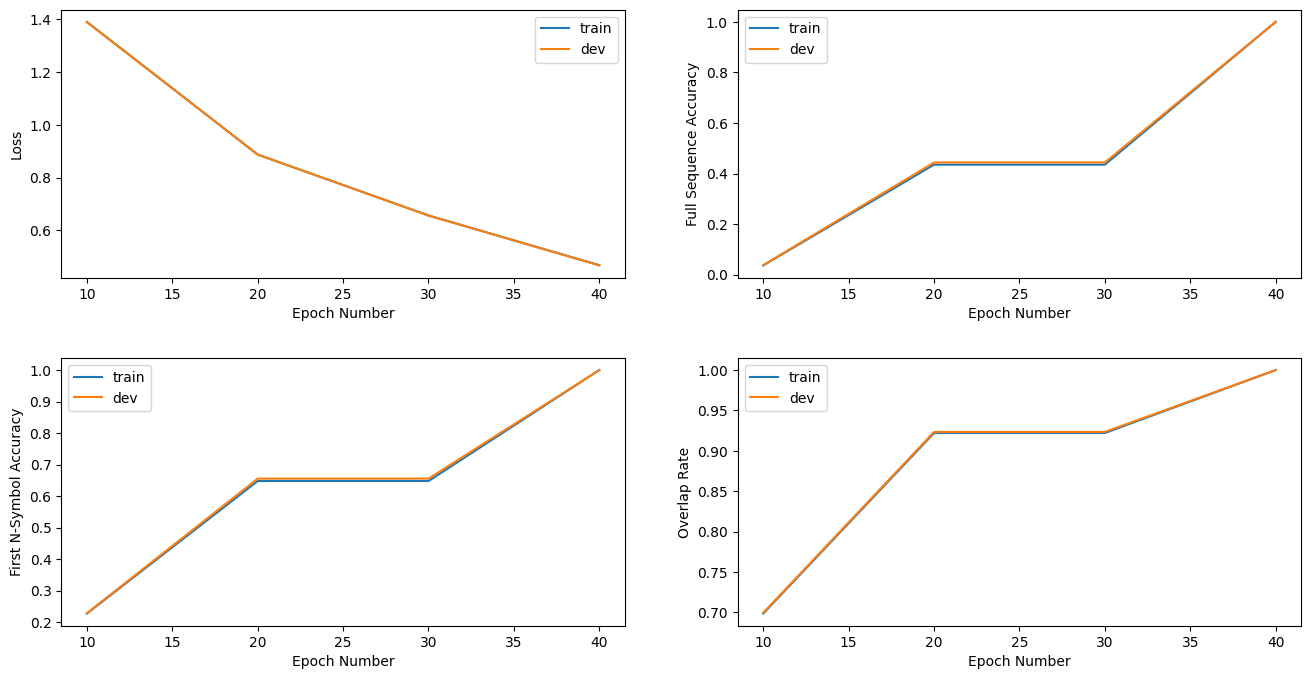

In [11]:
plot_training_log(log)

## Save model

In [12]:
save_dict_as_json(ModelConfig, f"models/{rnn_type}/ModelConfig.json")

models/SRNN/ModelConfig.json saved!


## Evaluation 

In [13]:
eavl1 = evaluate(model, test_dl, criterion)
eavl1

{'loss': 0.4660031994183858,
 'full sequence accuracy': 1.0,
 'first n-symbol accuracy': 1.0,
 'overlap rate': 1.0}

In [14]:
eavl2 = evaluate(model, test_dl2, criterion)
eavl2

{'loss': 0.4661344140768051,
 'full sequence accuracy': 1.0,
 'first n-symbol accuracy': 1.0,
 'overlap rate': 1.0}

# GRU

## Training 

In [15]:
set_seed(3422)

In [16]:
ModelConfig["rnn_type"] = "GRU"
rnn_type = ModelConfig["rnn_type"]
create_dir(f"models/{rnn_type}")
model = get_model(ModelConfig)

./models/GRU created!
The model has 316 trainable parameters


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp=f"models/{rnn_type}/model.pt", 
                         acc_threshold=0.0, # if this is set greater than 1.0, no model will be saved.
                         print_eval_freq=10, max_epoch_num=500, 
                         train_exit_acc=1.0, eval_exit_acc=1.0)

Current epoch: 10, 
training performance: {'loss': 1.4130235314369202, 'full sequence accuracy': 0.011200000000000002, 'first n-symbol accuracy': 0.14583892524142525, 'overlap rate': 0.5899053782328781}
evaluation performance: {'loss': 1.4142317533493043, 'full sequence accuracy': 0.009600000000000001, 'first n-symbol accuracy': 0.1418847116772117, 'overlap rate': 0.5879631365856366}

Current epoch: 20, 
training performance: {'loss': 0.9107647597789764, 'full sequence accuracy': 0.0913, 'first n-symbol accuracy': 0.3267140612165612, 'overlap rate': 0.7814037004662004}
evaluation performance: {'loss': 0.9128471970558166, 'full sequence accuracy': 0.0927, 'first n-symbol accuracy': 0.3240394155844156, 'overlap rate': 0.7791789427239427}

Current epoch: 30, 
training performance: {'loss': 0.6101969122886658, 'full sequence accuracy': 0.2156, 'first n-symbol accuracy': 0.4800970515595515, 'overlap rate': 0.8569137767787769}
evaluation performance: {'loss': 0.6122413575649261, 'full sequen

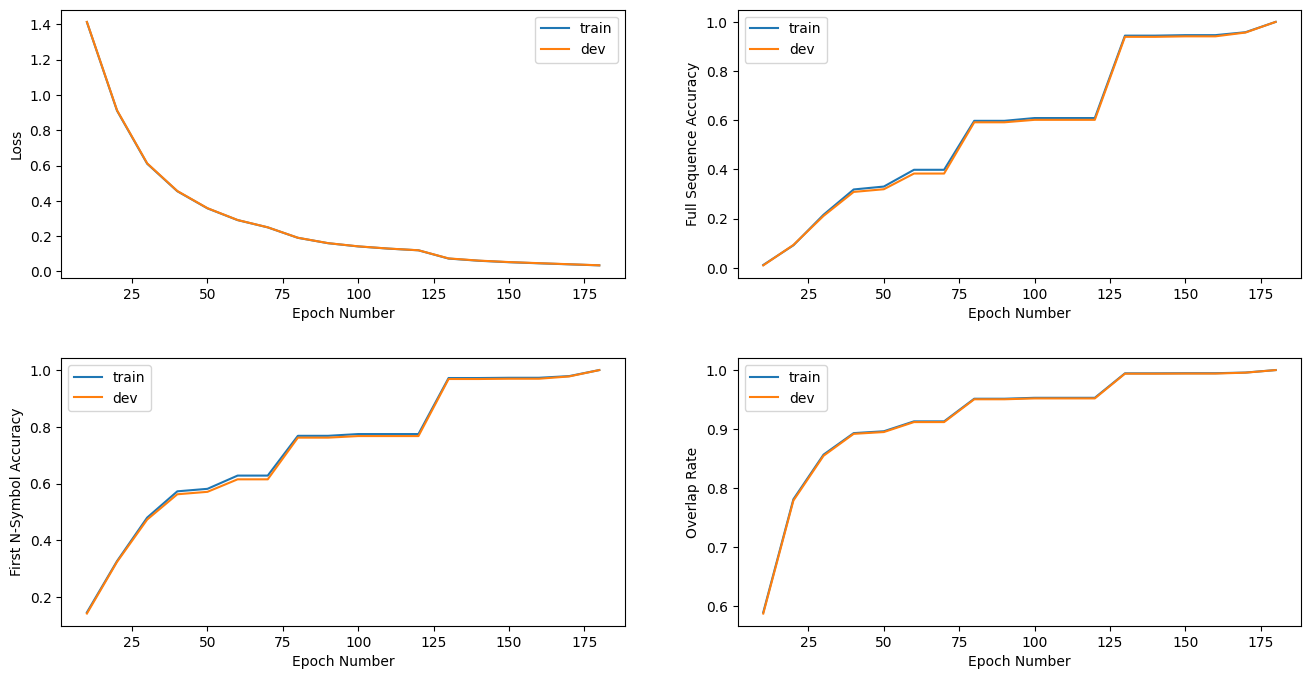

In [18]:
plot_training_log(log)

## Save model

In [19]:
save_dict_as_json(ModelConfig, f"models/{rnn_type}/ModelConfig.json")

models/GRU/ModelConfig.json saved!


## Evaluation 

In [20]:
eavl1 = evaluate(model, test_dl, criterion)
eavl1

{'loss': 0.03363597057759762,
 'full sequence accuracy': 1.0,
 'first n-symbol accuracy': 1.0,
 'overlap rate': 1.0}

In [21]:
eavl2 = evaluate(model, test_dl2, criterion)
eavl2

{'loss': 0.034935027733445166,
 'full sequence accuracy': 1.0,
 'first n-symbol accuracy': 1.0,
 'overlap rate': 1.0}

# LSTM

## Training

In [22]:
set_seed(3422)

In [23]:
ModelConfig["rnn_type"] = "LSTM"
rnn_type = ModelConfig["rnn_type"]
create_dir(f"models/{rnn_type}")
model = get_model(ModelConfig)

./models/LSTM created!
The model has 352 trainable parameters


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp=f"models/{rnn_type}/model.pt", 
                         acc_threshold=0.0, # if this is set greater than 1.0, no model will be saved.
                         print_eval_freq=10, max_epoch_num=500, 
                         train_exit_acc=1.0, eval_exit_acc=1.0)

Current epoch: 10, 
training performance: {'loss': 1.5038331389427184, 'full sequence accuracy': 0.0043, 'first n-symbol accuracy': 0.10498590409590411, 'overlap rate': 0.5123649231324231}
evaluation performance: {'loss': 1.5035634517669678, 'full sequence accuracy': 0.0031000000000000008, 'first n-symbol accuracy': 0.1050126923076923, 'overlap rate': 0.5108209887334887}

Current epoch: 20, 
training performance: {'loss': 0.9296317040920258, 'full sequence accuracy': 0.027800000000000002, 'first n-symbol accuracy': 0.21326061050061051, 'overlap rate': 0.66483987012987}
evaluation performance: {'loss': 0.9272612273693085, 'full sequence accuracy': 0.030300000000000004, 'first n-symbol accuracy': 0.21621421855921857, 'overlap rate': 0.6652018237318239}

Current epoch: 30, 
training performance: {'loss': 0.7476207554340363, 'full sequence accuracy': 0.084, 'first n-symbol accuracy': 0.30774530636030645, 'overlap rate': 0.7668985370185369}
evaluation performance: {'loss': 0.744915682077407

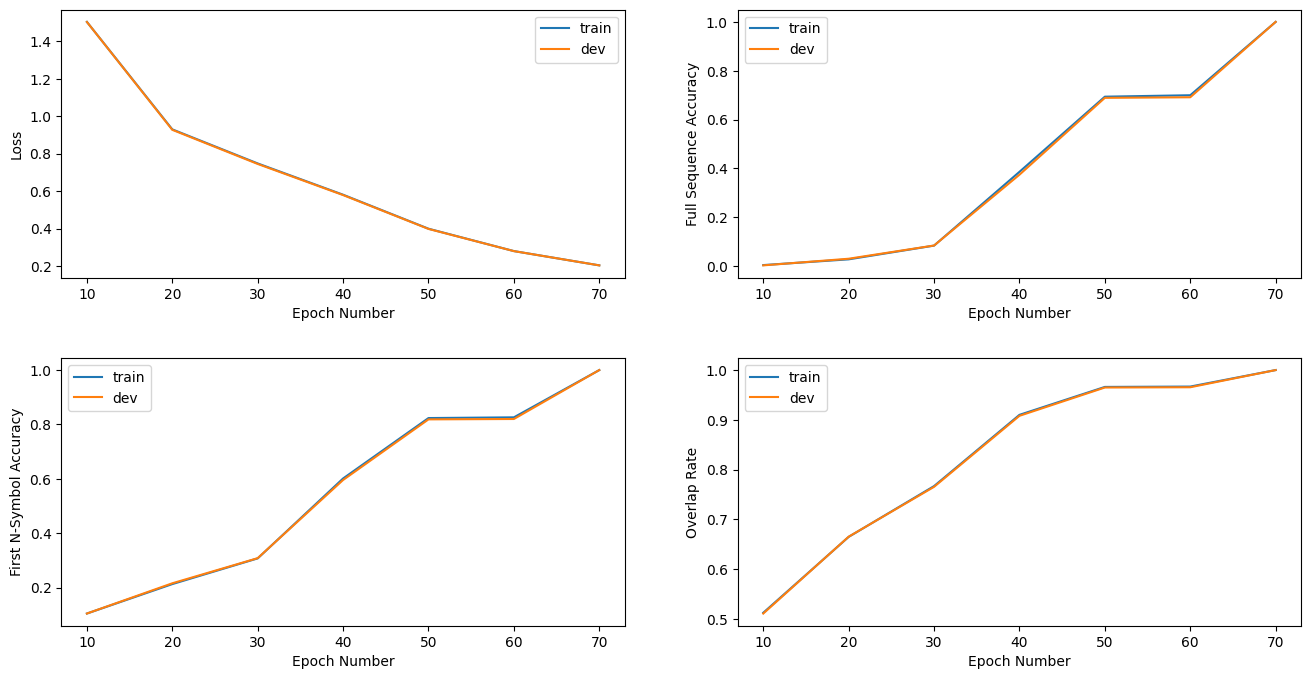

In [25]:
plot_training_log(log)

## Save model

In [26]:
save_dict_as_json(ModelConfig, f"models/{rnn_type}/ModelConfig.json")

models/LSTM/ModelConfig.json saved!


## Evaluation

In [27]:
eavl1 = evaluate(model, test_dl, criterion)
eavl1

{'loss': 0.20323300908009212,
 'full sequence accuracy': 1.0,
 'first n-symbol accuracy': 1.0,
 'overlap rate': 1.0}

In [28]:
eavl2 = evaluate(model, test_dl2, criterion)
eavl2

{'loss': 0.20121325999498368,
 'full sequence accuracy': 1.0,
 'first n-symbol accuracy': 1.0,
 'overlap rate': 1.0}